In [12]:
import os
import torch
import torchvision as tv
import numpy as np
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
from utils import makedirs, tensor2cuda, load_model, LabelDict
from argument import parser
from visualization import VanillaBackprop
from model.madry_model import WideResNet
import patch_dataset as patd
import matplotlib.pyplot as plt 
from skimage.color import rgb2gray
from model.resnetdsbn import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
out_num = 1
data_root = '../CheXpert_Dataset/images_256/images/'
transform_test = tv.transforms.Compose([
        tv.transforms.Resize((256, 256)),
        tv.transforms.ToTensor()
        ])
te_dataset = patd.PatchDataset(path_to_images=data_root, fold='test',
                               transform=tv.transforms.ToTensor())
te_loader = DataLoader(te_dataset, batch_size=1, shuffle=False, num_workers=1)

In [37]:
counter = 0
for data, label in te_loader:
    if int(np.sum(label.squeeze().numpy())) > 0:
        disease = ''
        for i in range(int(np.sum(label.squeeze().numpy()))):
            disease_index = np.nonzero(label.squeeze().numpy())[0][i]
            dis_temp = te_dataset.PRED_LABEL[disease_index]
            disease = disease + ' ' + dis_temp

        data, label = tensor2cuda(data), tensor2cuda(label)
        model = resnet50dsbn(pretrained=False, widefactor=1)
        num_classes=8
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        load_model(model, './checkpoint/chexpert_linf_full/checkpoint_best.pth')
        if torch.cuda.is_available():
            model.cuda()

        VBP = VanillaBackprop(model)
        grad = VBP.generate_gradients(data, label) # data: (1,3,96,96) label: (1,3)
        grad_flat = grad.view(grad.shape[0], -1) # grad: (1, 3x96x96)
        mean = grad_flat.mean(1, keepdim=True).unsqueeze(2).unsqueeze(3) # (1,1,1,1)
        std = grad_flat.std(1, keepdim=True).unsqueeze(2).unsqueeze(3) # (1,1,1,1)
        mean = mean.repeat(1, 1, data.shape[2], data.shape[3])
        std = std.repeat(1, 1, data.shape[2], data.shape[3])
        grad = torch.max(torch.min(grad, mean+3*std), mean-3*std)
        print(grad.min(), grad.max())
        grad -= grad.min()
        grad /= grad.max()
        grad = grad.cpu().numpy().squeeze()  # (N, 28, 28)
        grad *= 255.0
        label = label.cpu().numpy()
        data = data.cpu().numpy().squeeze()
        data *= 255.0
        out_list = [data, grad]
        print('data shape ', data.shape)
        print('grad shape ', grad.shape)
        print(disease)
        counter += 1
        if counter == 4:
            break

DSBNResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): DomainSpecificBatchNorm2d(
    (bns): ModuleList(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
  )
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): TwoInputSequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): DomainSpecificBatchNorm2d(
        (bns): ModuleList(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): DomainSpecificBatchNor

tensor(-0.0076, device='cuda:0') tensor(0.0076, device='cuda:0')
data shape  (3, 256, 256)
grad shape  (3, 256, 256)
 Cardiomegaly


DSBNResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): DomainSpecificBatchNorm2d(
    (bns): ModuleList(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
  )
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): TwoInputSequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): DomainSpecificBatchNorm2d(
        (bns): ModuleList(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): DomainSpecificBatchNor

tensor(-0.0043, device='cuda:0') tensor(0.0043, device='cuda:0')
data shape  (3, 256, 256)
grad shape  (3, 256, 256)
 Edema


DSBNResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): DomainSpecificBatchNorm2d(
    (bns): ModuleList(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
  )
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): TwoInputSequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): DomainSpecificBatchNorm2d(
        (bns): ModuleList(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): DomainSpecificBatchNor

tensor(-0.0031, device='cuda:0') tensor(0.0031, device='cuda:0')
data shape  (3, 256, 256)
grad shape  (3, 256, 256)
 No Finding


DSBNResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): DomainSpecificBatchNorm2d(
    (bns): ModuleList(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
  )
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): TwoInputSequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): DomainSpecificBatchNorm2d(
        (bns): ModuleList(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): DomainSpecificBatchNor

tensor(-0.0071, device='cuda:0') tensor(0.0071, device='cuda:0')
data shape  (3, 256, 256)
grad shape  (3, 256, 256)
 Atelectasis Pleural Effusion


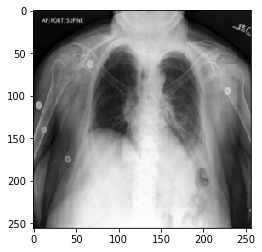

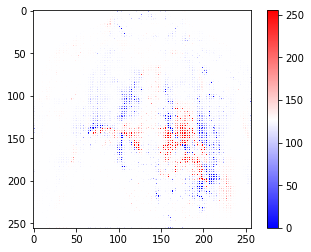

In [38]:
plt.imshow(data[0], cmap='gray')
plt.show()
plt.imshow(grad[1], cmap='bwr')
plt.colorbar()